In [1]:
Name = "Lavanyaa Gupta"

# About the Project
- Project 2 is a continuation of Project 1, this time in Python. This project aims to translate all analyses that were previously conducted in R into Python with some more expansion on the analysis to provide further insight.

- This time, I will also be adding a Survival Analysis for Alzheimer's patients. Many view Alzheimer's as a fatal disease as it is neurodegenerative, but at what point does this disease truly become fatal?

# Background
- Last time, we established Alzheimer's as a "type of dementia that affects memory, thinking, and behavior"
- Since there is no cure, this project hopes to understand progression indicators to potentially prevent further progression of the disease or contributing factors of the disease.

# Variable Descriptions
- Subject ID: unique participant identifier
- M/F: identifies male or female participant
- Hand: right/left hand dominance. Typically, scientific studies do not include left hand dominant participants.
- Educ: refers to education level; the manner in which numbers are attributed is unknown.
- SES: socioeconomic status
- MMSE: mini-mental state examination
- CDR: clinical dementia rating
- eTIV: estimated total intracranial volume
- nWBV: Normalize Whole Brain Volume
- ASF: Atlas Scaling Factor
- Delay: unknown, likely some type of error

# Hypothesis: Higher levels of Education and SES are associated with a slower progression of cognitive decline in individuals with Alzheimer's disease.
- This hypothesis is similar but DISTINCT from the original hypothesis, specifically looking at cogntive decline and potential survival rate rather than looking specifically clinical dementia rating.

In [2]:
# First, import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv
from lifelines import KaplanMeierFitter
from sklearn.model_selection import cross_val_score
from lifelines import CoxPHFitter

In [3]:
# Then, import the dataset -- the same one as last time.
oasis_cross_sectional = pd.read_csv("C:/Users/lavan/Downloads/oasis_cross_sectional.csv")
print(oasis_cross_sectional.head()) # verifies that the dataset was imported correctly

              ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306   
1  OAS1_0002_MR1   F    R   55   4.0  1.0  29.0  0.0  1147  0.810  1.531   
2  OAS1_0003_MR1   F    R   73   4.0  3.0  27.0  0.5  1454  0.708  1.207   
3  OAS1_0004_MR1   M    R   28   NaN  NaN   NaN  NaN  1588  0.803  1.105   
4  OAS1_0005_MR1   M    R   18   NaN  NaN   NaN  NaN  1737  0.848  1.010   

   Delay  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  


# Statistical Analysis of Dataset

In [4]:
# Mean of SES and Education
SES_mean = oasis_cross_sectional['SES'].mean()
SES_sd = oasis_cross_sectional['SES'].std()
print(SES_mean)
print(SES_sd)

Educ_mean = oasis_cross_sectional['Educ'].mean()
Educ_sd = oasis_cross_sectional['Educ'].std()
print(Educ_mean)
print(Educ_sd)

# Filter data within 3 standard deviations to separate groups
oasis_cross_sectional = oasis_cross_sectional[
    (oasis_cross_sectional['SES'] > (SES_mean - 3 * SES_sd)) &
    (oasis_cross_sectional['SES'] < (SES_mean + 3 * SES_sd)) &
    (oasis_cross_sectional['Educ'] > (Educ_mean - 3 * Educ_sd)) &
    (oasis_cross_sectional['Educ'] < (Educ_mean + 3 * Educ_sd))
]

# Create an age group column
age_bins = [50, 60, 70, 80, 90, 100]
age_labels = ["50-59", "60-69", "70-79", "80-89", "90+"]
oasis_cross_sectional['Age_Group'] = pd.cut(oasis_cross_sectional['Age'], bins=age_bins, right=False, labels=age_labels)

2.490740740740741
1.120592620377316
3.178723404255319
1.3115098903167373


# Plotting

In [5]:
print(oasis_cross_sectional.columns) #verifying names of columns before beginning analysis to prevent syntax errors

Index(['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV',
       'nWBV', 'ASF', 'Delay', 'Age_Group'],
      dtype='object')


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(


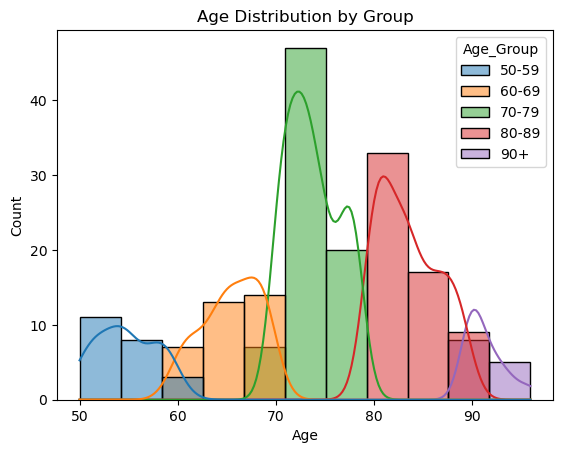

                            OLS Regression Results                            
Dep. Variable:                   MMSE   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     5.436
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           1.03e-05
Time:                        22:31:29   Log-Likelihood:                -521.23
No. Observations:                 202   AIC:                             1058.
Df Residuals:                     194   BIC:                             1085.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             37.7034      5

In [7]:
# Creating an Age Distribution by Group is Necessary to Verify the Hypothesis
sns.histplot(data=oasis_cross_sectional, x="Age", hue="Age_Group", kde=True)
plt.title("Age Distribution by Group")
plt.show()

# Linear regression model 
model = ols("MMSE ~ Age + SES + Educ + Age_Group", data=oasis_cross_sectional).fit()
print(model.summary())

# Save cleaned data for further use if necessary
oasis_cross_sectional.to_csv("oasis_cleaned.csv", index=False)

This plot visualizes the age distribution across different age groups in the dataset. Each age group is represented by distinct color-coded histograms to show the frequency and spread of ages. The distributions show overlap but also highlight the concentration of ages within each group, particularly a higher frequency of individuals aged 70–79 and 80–89. 

In [8]:
# Perform linear regression
model = ols("MMSE ~ Age + SES + Educ + Age_Group", data=oasis_cross_sectional).fit()

# Display the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MMSE   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     5.436
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           1.03e-05
Time:                        22:31:42   Log-Likelihood:                -521.23
No. Observations:                 202   AIC:                             1058.
Df Residuals:                     194   BIC:                             1085.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             37.7034      5

This linear model explains 16.4% of the variance in MMSE scores (R^2 = 0.164), indicating a weak relationship between Age, SES, Education, and Age Groups and MMSE. Age has a significant negative effect (p = 0.041), suggesting scores decline slightly with age, while SES and Education are not statistically significant predictors. None of the categorical Age Groups show significant differences in MMSE. 

In [9]:
# Perform ANOVA
anova_model = ols("MMSE ~ Age_Group", data=oasis_cross_sectional).fit()
anova_results = anova_lm(anova_model)
print(anova_results)

              df       sum_sq   mean_sq         F    PR(>F)
Age_Group    4.0   203.031241  50.75781  4.419472  0.001921
Residual   197.0  2262.552918  11.48504       NaN       NaN


The ANOVA analysis shows that the categorical variable Age_Group has a statistically significant effect on MMSE scores (F = 4.42, p = 0.0019). This suggests that at least one age group differs significantly in terms of cognitive performance. The sum of squares for Age_Group (203.03) represents a relatively small proportion of the total variation compared to the residual sum of squares (2262.55), indicating that while Age_Group has a significant impact, it accounts for only a modest amount of variability in MMSE scores. 

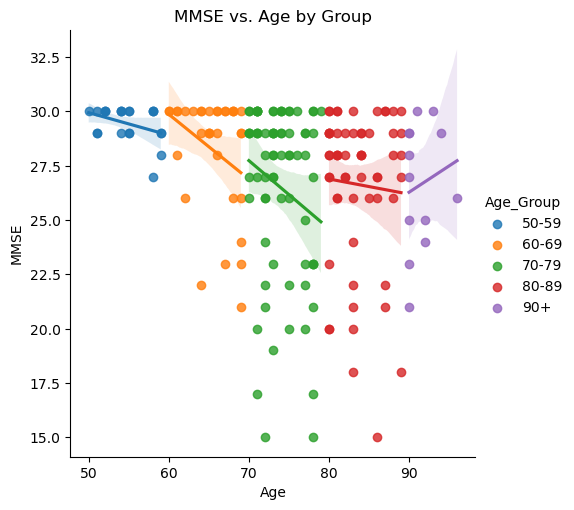

In [10]:
# Scatter plot with regression line
sns.lmplot(x="Age", y="MMSE", hue="Age_Group", data=oasis_cross_sectional)
plt.title("MMSE vs. Age by Group")
plt.show()

The scatter plot shows the relationship between MMSE scores and age, with data points grouped by age category. There is a clear downward trend in MMSE scores as age increases, particularly after the 70-79 age group. The trend shows a significant decrease in cognitive function as individuals age, with those in the 80-89 and 90+ groups showing notably lower MMSE scores.

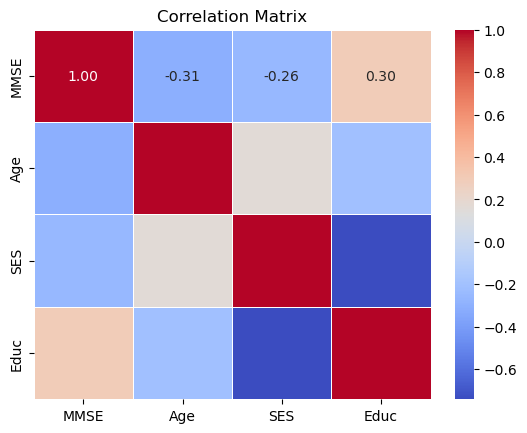

In [11]:
# Calculate the correlation matrix
cor_matrix = oasis_cross_sectional[["MMSE", "Age", "SES", "Educ"]].corr()

# Plot the correlation matrix using seaborn heatmap
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

The correlation matrix reveals that MMSE has a moderate negative correlation with Age (-0.31) and SES (-0.26), and a positive correlation with Educ (0.30). Age is negatively correlated with both SES (-0.40) and Educ (-0.46). There is also a weak negative correlation between SES and Educ (-0.24), indicating some inverse relationship between these two variables.

In [12]:
# Save the cleaned dataset to a CSV file
oasis_cross_sectional.to_csv("oasis_cleaned.csv", index=False)

# Analysis

What is VIF? measure of the amount of multicollinearity in regression analysis
Multicollinearity exists when there is a correlation between multiple independent variables in a multiple regression model.
We need to calculate VIF and verify multicollinearity to observe the many independent variables in the model.

In [13]:
# VIF Calculation
# Select numeric columns
X = oasis_cross_sectional[["Age", "SES", "Educ"]]

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

  feature        VIF
0     Age  18.881860
1     SES   7.735319
2    Educ   6.881891


The VIF for Age is quite high at 18.88, suggesting strong collinearity with other variables in the model and potential issues with the stability of coefficient estimates. Both SES and Educ have moderate VIFs of 7.74 and 6.88, respectively, indicating some degree of collinearity, though not as severe as with Age.

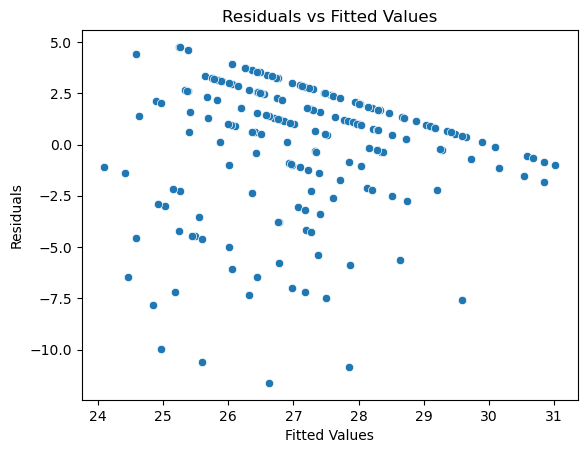

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


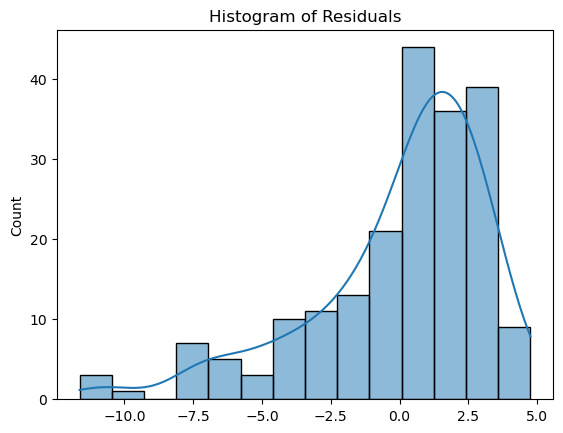

In [14]:
# Residuals plot
residuals = model.resid
fitted_values = model.fittedvalues

sns.scatterplot(x=fitted_values, y=residuals)
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

# Histogram of residuals for normality
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

The first plot shows the residuals versus the fitted values from the regression model predicting MMSE using Age, SES, Educ, and Age Group. The residuals are centered around zero to capture the general trend of the data. However, a few outliers may influence the model. Further diagnostics, such as a Q-Q plot or tests for heteroscedasticity, could help understand model assumptions.

This second plot, the histogram, visualizes the distribution of the residuals from the regression model predicting MMSE using Age, SES, Educ, and Age Group. The residuals are mostly centered around zero, with a skew towards negative values, so the model slightly overestimates MMSE for certain cases. 

In [15]:
# Linear regression with interaction term between Age and SES
model_interaction = ols("MMSE ~ Age * SES + Educ + Age_Group", data=oasis_cross_sectional).fit()
print(model_interaction.summary())

                            OLS Regression Results                            
Dep. Variable:                   MMSE   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     5.529
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           2.66e-06
Time:                        22:34:42   Log-Likelihood:                -518.48
No. Observations:                 202   AIC:                             1055.
Df Residuals:                     193   BIC:                             1085.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             29.5363      6

The regression analysis suggests that SES has a statistically significant positive relationship with MMSE scores (𝑝 = 0.038), indicating that higher SES is associated with better cognitive performance. The interaction term between Age and SES (𝑝 = 0.022) is also significant, suggesting that the effect of SES on MMSE decreases with age. However, other predictors, such as age group and years of education, were not statistically significant.

# Extended Analysis: Cognitive Decline using Oasis_Longitudinal Data

Variables
- Subject ID: unique participant identifier
- MRI ID: unique MRI scan identifier that corresponds to Subject ID
- Group: Identifies whether patient presents Dementia symptoms
- Visit: this data set is longitudinal, therefore, each patient may attend more than one visit to the particular clinic. Multiple visits allows us to monitor progression signs.
- MR Delay: unknown
- Hand, M/F, Age, EDUC, MMSE, CDR, eTIV, nWB, and ASF are all the same as cross-sectional

In [16]:
#Set Up
oasis_longitudinal = pd.read_csv("C:/Users/lavan/Downloads/oasis_longitudinal.csv")
print(oasis_longitudinal.head()) # verifies that the dataset was imported correctly

  Subject_ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14   
1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88    14   
2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12   
3  OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76    12   
4  OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80    12   

   SES  MMSE  CDR  eTIV   nWBV    ASF  
0  2.0  27.0  0.0  1987  0.696  0.883  
1  2.0  30.0  0.0  2004  0.681  0.876  
2  NaN  23.0  0.5  1678  0.736  1.046  
3  NaN  28.0  0.5  1738  0.713  1.010  
4  NaN  22.0  0.5  1698  0.701  1.034  


In [17]:
print(oasis_longitudinal.columns)

Index(['Subject_ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand',
       'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')


In [22]:
# This step is for my own ease in analysis in the next step
le = LabelEncoder()
oasis_longitudinal['Sex'] = le.fit_transform(oasis_longitudinal['M/F'])  # 'M' -> 0, 'F' -> 1
oasis_longitudinal = oasis_longitudinal.dropna()

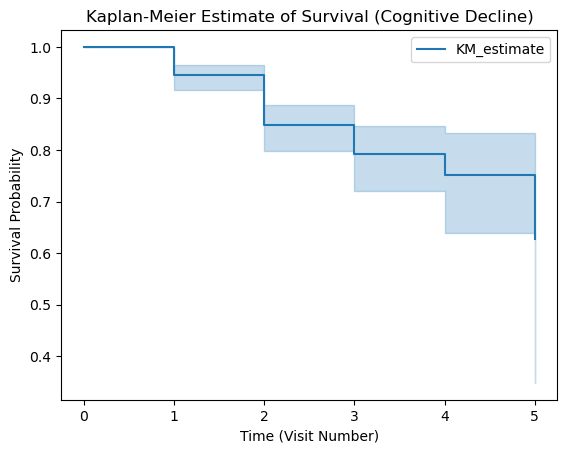

<lifelines.CoxPHFitter: fitted with 354 total observations, 306 right-censored observations>
             duration col = 'time_to_decline'
                event col = 'cognitive_decline'
      baseline estimation = breslow
   number of observations = 354
number of events observed = 48
   partial log-likelihood = -242.54
         time fit was run = 2024-12-09 05:47:18 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Age        -0.04       0.96       0.02            -0.08            -0.01                 0.92                 0.99
Sex         0.60       1.83       0.29             0.03             1.18                 1.03                 3.24
EDUC       -0.18       0.84       0.07            -0.32            -0.03                 0.72                 0.97
SES         0.09       1.09       0.18            -0.27             0.45                 0.76                 1.56

            cmp to     z    p   -log2(p)
covariate                               
Age           0.00 -2.31 0.02       5.56
Sex           0.00  2.07 0.04       4.71
EDUC          0.00 -2.37 0.02       5.82
SES           0.00  0.48 0.63       0.66
---
Concordance = 0.69
Partial AIC = 493.07
log-likelihood ratio test = 22.89 on 4 df
-log2(p) of ll-ratio test = 12.87

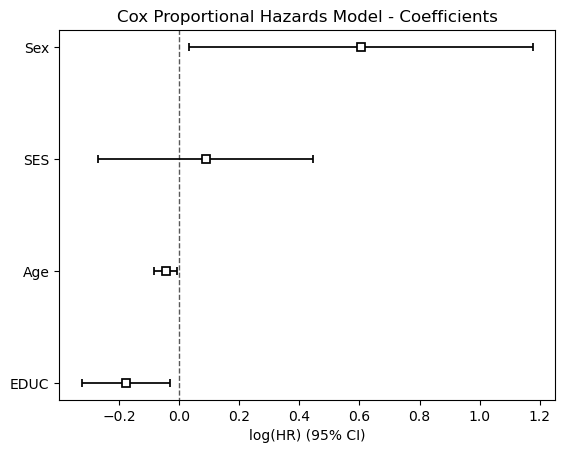

In [23]:
# Extended Analysis: Cognitive Decline

# Define cognitive decline based on MMSE
threshold = 24  # MMSE threshold for cognitive decline
oasis_longitudinal['cognitive_decline'] = oasis_longitudinal['MMSE'].apply(lambda x: 1 if x < threshold else 0)

# Define time-to-decline as Visit 
oasis_longitudinal['time_to_decline'] = oasis_longitudinal['Visit']  

# Kaplan-Meier Survival Analysis
kmf = KaplanMeierFitter()
kmf.fit(oasis_longitudinal['time_to_decline'], event_observed=oasis_longitudinal['cognitive_decline'])

# Plot the Kaplan-Meier survival curve
kmf.plot()
plt.title("Kaplan-Meier Estimate of Survival (Cognitive Decline)")
plt.xlabel("Time (Visit Number)")
plt.ylabel("Survival Probability")
plt.show()

# Cox Proportional Hazards Model
cox_data = oasis_longitudinal[['Age', 'Sex', 'EDUC', 'SES', 'time_to_decline', 'cognitive_decline']]
cph = CoxPHFitter()
cph.fit(cox_data, duration_col='time_to_decline', event_col='cognitive_decline')
cph.print_summary()

# Plot the coefficients 
cph.plot()
plt.title("Cox Proportional Hazards Model - Coefficients")
plt.show()

The Cox Proportional Hazards model results suggest several key insights into the risk of cognitive decline:

- Age has a negative association with cognitive decline. For every additional year of age, the risk of cognitive decline decreases by about 6%, and this result is statistically significant (p < 0.005).
- Sex does not show a significant impact on the risk of cognitive decline, as indicated by a hazard ratio of 0.96 and a high p-value of 0.91.
- EDUC also demonstrates a negative association, with a coefficient of -0.18. This indicates that higher levels of education decrease the likelihood of the cognitive decline!
- SES has a confidence interval (-0.27 to 0.45) includes zero, and the p-value of 0.63 is not statistically significant, indicating that SES does not significantly predict the outcome in this model.

# Conclusion

**It is likely that Education is correlated with cognitive decline, but SES likely is not.** With the Cox Proportional Hazards, it is likely that the model can firmly identify cognitive decline, however it is important to note that each visit could indicate differing levels of cognitive decline from visit to visit and not necessarily guarantee progressing cognitive decline due to confounding and genetic factors.
Generally, the hypothesis is implied to be true but not entirely correct. All things considered, this study needs far more patients to confirm the results as 300 patients is a small sample size when considering the gravity of the outcomes of this study.

# Sources

Boysen, J. (2020). *MRI and Alzheimer's Disease*. Kaggle. https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers?resource=download